Ref: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [1]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
excludes_sites = ['Boskednan,']
excludes_features = ['other']

df = pd.read_csv(
    "data_clean.csv",
    index_col=[1,0],
    )
df.index = df.index.droplevel(0)  # read it in with areas but then get rid of them for now
df = df.fillna(0)
df = df.replace(['y', 'Y', '?'], [1, 1, 0.5])
df = df.astype(int)
# df = df.sort_index()
df.index = df.index.str.strip()
df = df[~df.index.isin(excludes_sites)]
df = df[df.columns[~df.columns.isin(excludes_features)]]
df

,standing stones/boulders,orthostats/boulders and bank,ditch and bank,bank,stones on or protrude from mound,"other, inc once below mound",regularly spaced,irregularly spaced,contiguoius,bank faced inside,...,paired stones outside,avenue row,other.2,part of complex,other.3,diam 1,diam 2,diam 3,diam 4,Unnamed: 50
Name,,,,,,,,,,,,,,,,,,,,,
Cerrig Pryfraid,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Brankam Hill 2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
Upper Auchnagorth,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Abercross,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Achanarass Hill,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Lacra B,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Llacra D,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
Sdtanton Drew,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [3]:
def plot_dendrogram_from_df(df, method):
    X = df.values
    Z = linkage(X, method=method)

    c, coph_dists = cophenet(Z, pdist(X))

    plt.figure(figsize=(10, 25))
    plt.title(f'Hierarchical Clustering, {method} method\ncophenet: {c:.2f}')
    plt.xlabel('Distance')
    plt.ylabel('Site')
    dendrogram(
        Z,
        orientation='right',
        leaf_font_size=8.,  # font size for the x axis labels,
        labels=df.index,
        truncate_mode='level',
        # p=4
    )
    plt.savefig(f"clustering - {method}.png")
    return Z

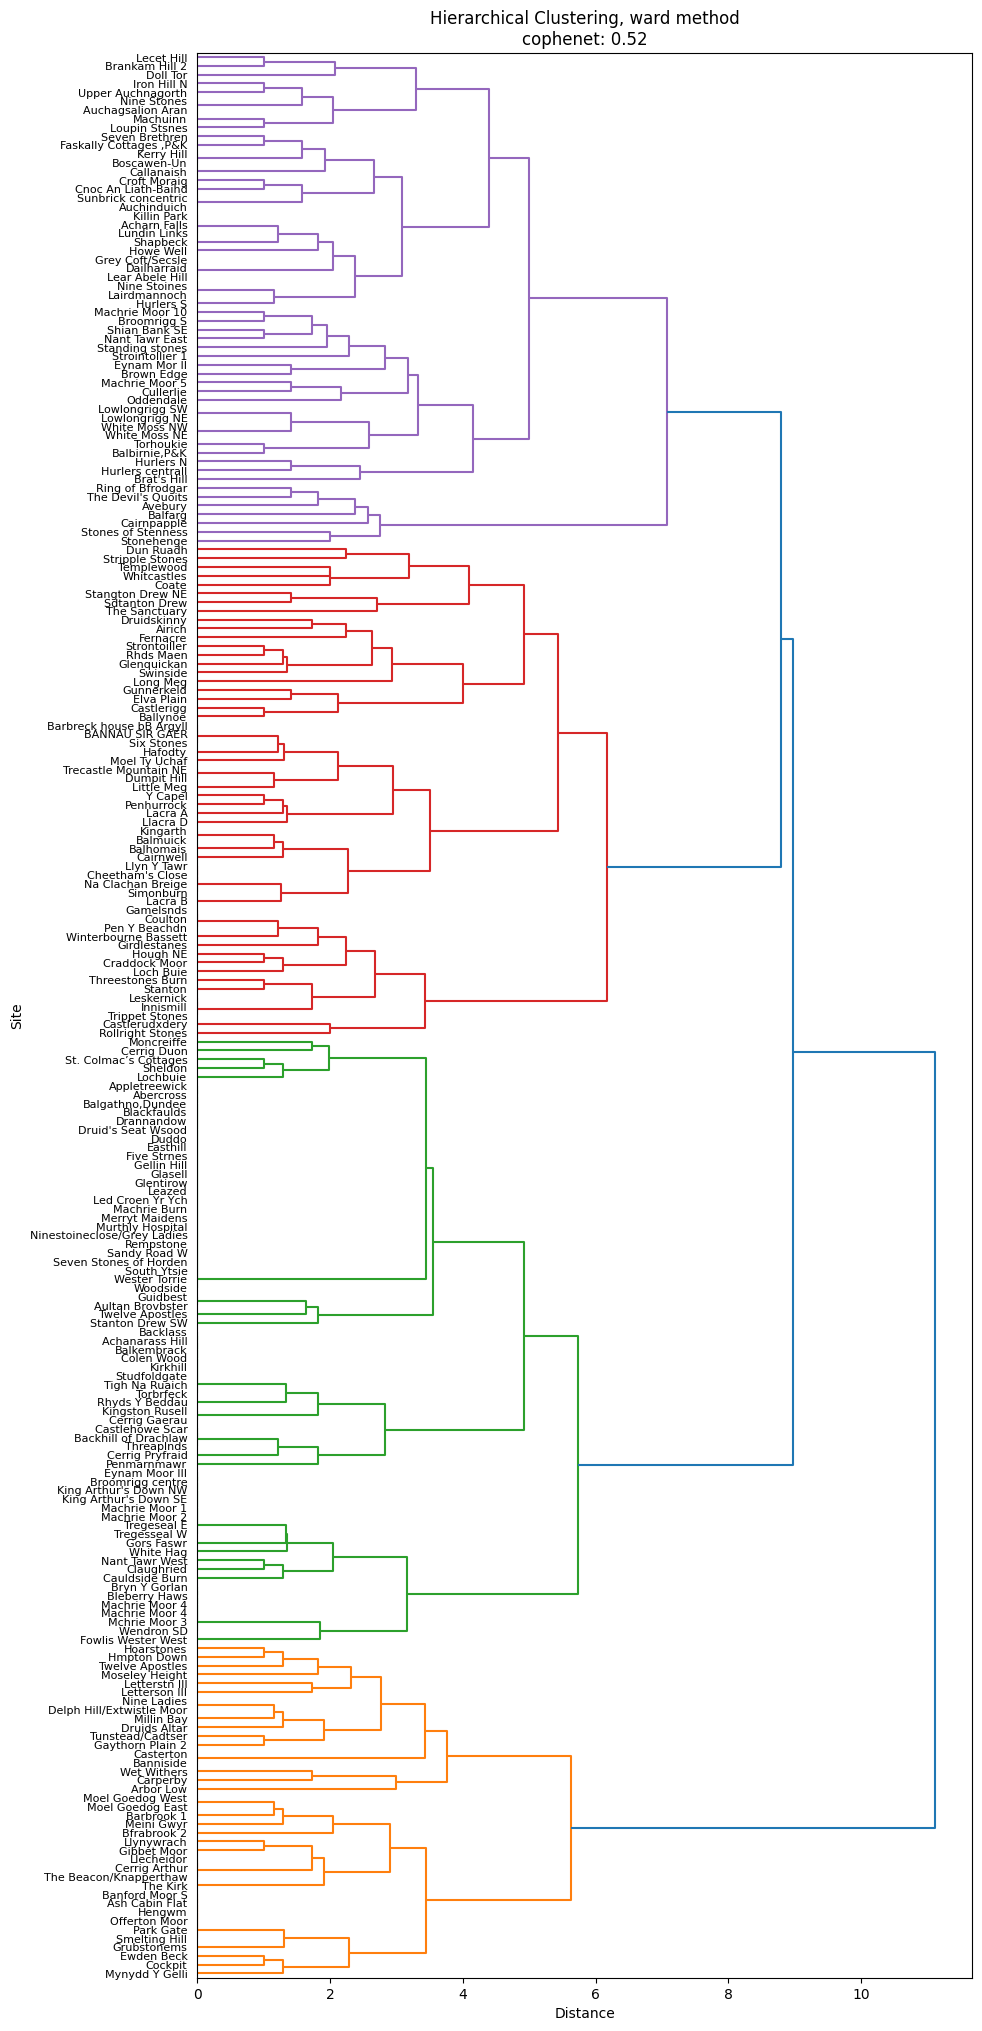

In [4]:
methods = [
    # 'single',
    # 'complete',
    # 'average',
    # 'weighted',
    # 'centroid',
    # 'median',
    'ward'
    ]

linkages = {method: plot_dendrogram_from_df(df, method) for method in methods}

In [5]:
n_clusters = 4
n_features = 10

L = linkages['ward']
df['clusters'] = fcluster(L, n_clusters, criterion='maxclust')
df.clusters = df.clusters.astype(str)  # for categorical plot labels

cluster_values = df.groupby('clusters').mean()

# compute difference metric
cluster_diffs = cluster_values.apply(lambda row: abs(cluster_values.iloc[cluster_values.index != row.name] - row).min(), axis=1)

# get top 10 columns by highest difference metric
col_order = cluster_diffs.max().T.sort_values(ascending=False).index
col_order = col_order[:n_features]

# reorder by value for cluster
# group_data = group_data[col_order]
# col_order = group_data.T.sort_values(by=['1'], ascending=False).index
cluster_diffs = cluster_diffs[col_order]
cluster_values = cluster_values[col_order]

fig = px.imshow(cluster_values, color_continuous_scale='greys')
fig.update_layout(title='Average value in cluster')
fig.show()
fig = px.imshow(cluster_diffs, color_continuous_scale='greys')
fig.update_layout(title='Difference metric')
fig.show()

In [6]:
diff_mask = cluster_diffs > 0.1
cluster_values_masked = cluster_values.mask(~diff_mask, np.nan)

for i, row in cluster_values_masked.iterrows():
    print(i)
    has = ', '.join(row.index[row > 0.5])
    hasnt = ', '.join(row.index[row < 0.5])
    if len(has):
        print(f"    has: {has}")
    if len(hasnt):
        print(f"    doesn't have: {hasnt}")
    

1
    has: orthostats/boulders and bank
    doesn't have: standing stones/boulders, bank faced inside
2
    has: nothing in interior, no perimeter focal point
    doesn't have: part of complex
3
    doesn't have: diam 2, no perimeter focal point, irregularly spaced
4
    has: standing stones/boulders
    doesn't have: nothing in interior, stone circle insiode, part of complex


In [7]:
from map_tools import get_lat_long_from_os

df_coords = pd.read_csv(
    "gridrefs_clean.csv",
    index_col=[1,0],
    )
df_coords.index = df_coords.index.droplevel(0)
df_coords = df_coords.dropna()

latlong_data = df_coords.apply(lambda row: get_lat_long_from_os(row.Gridref), axis='columns', result_type='expand')
latlong_data.columns = ['latitude', 'longitude']
df_coords = pd.concat([df_coords, latlong_data], axis='columns')

df = df.join(df_coords)
df

,standing stones/boulders,orthostats/boulders and bank,ditch and bank,bank,stones on or protrude from mound,"other, inc once below mound",regularly spaced,irregularly spaced,contiguoius,bank faced inside,...,other.3,diam 1,diam 2,diam 3,diam 4,Unnamed: 50,clusters,Gridref,latitude,longitude
Name,,,,,,,,,,,,,,,,,,,,,
Abercross,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,2,NH771990,57.963262,-4.079653
Achanarass Hill,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,2,ND145552,58.476620,-3.468011
Acharn Falls,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,4,NN767427,56.560029,-4.008468
Airich,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,3,NN959386,56.527862,-3.694323
Appletreewick,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,2,SK065632,53.165884,-1.904230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
White Moss NE,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,4,NY172024,54.410291,-3.277416
White Moss NW,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,4,NY172023,54.409392,-3.277388
Winterbourne Bassett,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,3,SV094755,50.448915,-7.517089


In [10]:
fig = px.scatter_mapbox(
    df.sort_values('clusters'),
    lat="latitude", 
    lon="longitude", 
    color='clusters',
    hover_name=df.index,
    hover_data=['Gridref'],
    zoom=3, 
    height=300
    )

fig.update_layout(
    mapbox_style= "carto-positron",
    mapbox_zoom=4, 
    mapbox_center_lat=55,
    margin={"r":0,"t":0,"l":0,"b":0},
    )

fig.show()